# NLP Model for flower detection

## Libraries and imports

In [1]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.7 MB/s 
     |████████████████████████████████| 86 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 33.6 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip3 install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=66719a577e8aa60178080a79e7e7ff12a412bd7dede7b6b5fd35df932901e563
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import string
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, RobertaTokenizer, RobertaModel
#from nltk.corpus import stopwords
from stop_words import get_stop_words

# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data and preproccess data

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/dzindili/Master-thesis/main/word_level.csv')

In [5]:
data = data.iloc[: , 1:]

In [6]:
data = data.dropna()

In [7]:
from sklearn.model_selection import train_test_split

#data = data.sample(frac=1).reset_index(drop=True)
train_flower, test_flower = train_test_split(data, test_size=0.1)

In [8]:
print(len(train_flower[train_flower['label']==1]))
print(len(test_flower[test_flower["label"] == 1]))

2514
270


In [9]:
train_dfflower = train_flower[['words', 'label']]

# Split data

### Split

In [10]:
train_inds, val_inds = next(GroupShuffleSplit(test_size=.1, n_splits=2, random_state = 7).split(train_dfflower, groups=train_dfflower['words']))
#print(train_inds, val_inds)
train, val = train_dfflower.iloc[train_inds], train_dfflower.iloc[val_inds]


train_text = train['words']
train_labels = train['label']
val_text = val['words']
val_labels = val['label']
#print(train_text, train_labels)

### Visualisations

label
0    45306
1     2514
dtype: int64


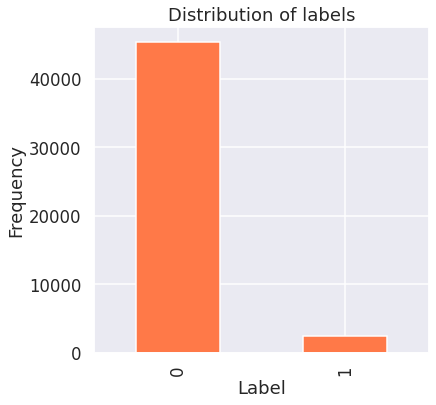

In [11]:
sns.set_theme()
sns.set(rc={'figure.figsize':(6,6)})
# sns.set_style("white")
sns.set_context("talk")

label_cnt = train_flower.groupby(['label']).size()
print(label_cnt)

plt = label_cnt.plot.bar(color='#ff7948')


plt.set_title('Distribution of labels')
plt.set_xlabel('Label')
plt.set_ylabel('Frequency')

plt.figure.savefig('dist.png', bbox_inches="tight")

# Train Data

In [12]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, BertConfig,BertTokenizer, BertModel

#BERT
#bert = AutoModel.from_pretrained('bert-large-uncased')
#tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

#MacBERTh
path = 'emanjavacas/MacBERTh'
tokenizer = BertTokenizer.from_pretrained(path)
bert = BertModel.from_pretrained(path)

#RoBERTa
#tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
#bert = RobertaModel.from_pretrained('roberta-large')


Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at emanjavacas/MacBERTh were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 8, #256
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 8, #256
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [16]:
#freeze all the parameters
#for param in bert.parameters():
#    param.requires_grad = True

In [17]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512) #768 for base, 1024 for large
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [18]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [19]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-6)          # learning rate

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
#class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
#class_weights = dict(zip(np.unique(train_labels), class_weights))

print("Class Weights:",class_weights)

Class Weights: [0.52811801 9.3910997 ]


In [21]:
# converting list of class weights to a tensor
weights = torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [22]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [23]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [24]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 5
  Batch    50  of  1,372.
  Batch   100  of  1,372.
  Batch   150  of  1,372.
  Batch   200  of  1,372.
  Batch   250  of  1,372.
  Batch   300  of  1,372.
  Batch   350  of  1,372.
  Batch   400  of  1,372.
  Batch   450  of  1,372.
  Batch   500  of  1,372.
  Batch   550  of  1,372.
  Batch   600  of  1,372.
  Batch   650  of  1,372.
  Batch   700  of  1,372.
  Batch   750  of  1,372.
  Batch   800  of  1,372.
  Batch   850  of  1,372.
  Batch   900  of  1,372.
  Batch   950  of  1,372.
  Batch 1,000  of  1,372.
  Batch 1,050  of  1,372.
  Batch 1,100  of  1,372.
  Batch 1,150  of  1,372.
  Batch 1,200  of  1,372.
  Batch 1,250  of  1,372.
  Batch 1,300  of  1,372.
  Batch 1,350  of  1,372.

Evaluating...
  Batch    50  of    123.
  Batch   100  of    123.

Training Loss: 0.320
Validation Loss: 0.300

 Epoch 2 / 5
  Batch    50  of  1,372.
  Batch   100  of  1,372.
  Batch   150  of  1,372.
  Batch   200  of  1,372.
  Batch   250  of  1,372.
  Batch   300  of  1,372.
  

# Test 

In [25]:
test_flower = test_flower[['words', 'label']]

In [26]:
#data = pd.read_csv('/content/test.csv')

In [27]:
#load weights of best model
path = '/content/saved_weights.pt'
# path = '../input/saved-model/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
test_flower

,words,label
40177,"red,",0
27761,for,0
49239,can,0
52052,wrote:,0
51302,with,0
...,...,...
38158,nutrition,0
50033,asked,0
32591,get,0
4874,pot-herbs,0


In [29]:
test_text = test_flower['words']

In [30]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 28,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [32]:
torch.cuda.empty_cache()

In [33]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [34]:
preds

array([[-0.01472216, -4.2257543 ],
       [-0.01387004, -4.2849483 ],
       [-0.01385206, -4.286236  ],
       ...,
       [-0.01370344, -4.296951  ],
       [-0.02021999, -3.911174  ],
       [-0.01435148, -4.2510657 ]], dtype=float32)

In [35]:
results =[]

for pred in preds:
  if pred[0] > pred[1]:
    results.append(0)
  if pred[0] < pred[1]:
    results.append(1)


In [36]:
test_flower['pred_values'] = results

label
0    5044
1     270
dtype: int64


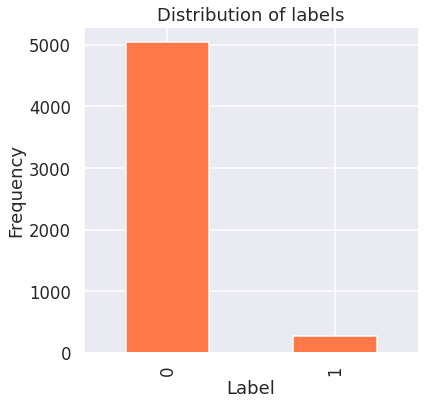

In [37]:
sns.set_theme()
sns.set(rc={'figure.figsize':(6,6)})
# sns.set_style("white")
sns.set_context("talk")

label_cnt = test_flower.groupby(['label']).size()
print(label_cnt)

plt = label_cnt.plot.bar(color='#ff7948')


plt.set_title('Distribution of labels')
plt.set_xlabel('Label')
plt.set_ylabel('Frequency')

plt.figure.savefig('dist.png', bbox_inches="tight")

In [38]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
y_true = test_flower[['label']]
y_pred = test_flower[['pred_values']]
precision_recall_fscore_support(y_true, y_pred, average='micro')

(0.9627399322544222, 0.9627399322544222, 0.9627399322544222, None)

In [39]:
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))

Accuracy: 0.963


In [40]:
print('Specificity: %.3f' % recall_score(y_true, y_pred, pos_label=0))

Specificity: 0.963


In [41]:
print('Recall: %.3f' % recall_score(y_true, y_pred))

Recall: 0.959


In [42]:
print('Precision: %.3f' % precision_score(y_true, y_pred))

Precision: 0.581


In [43]:
print('F1: %.3f' % f1_score(y_true, y_pred))

F1: 0.723


In [44]:
import sklearn
from sklearn import metrics

sklearn.metrics.roc_curve(y_true, y_pred)

(array([0.        , 0.03707375, 1.        ]),
 array([0.        , 0.95925926, 1.        ]),
 array([2, 1, 0]))

In [45]:
from sklearn.metrics import roc_auc_score
print('ROCAUC score:',roc_auc_score(y_true, y_pred))
print('Accuracy score:',accuracy_score(y_true, y_pred))
print('F1 score:',f1_score(y_true, y_pred))

ROCAUC score: 0.9610927541339912
Accuracy score: 0.9627399322544222
F1 score: 0.723463687150838


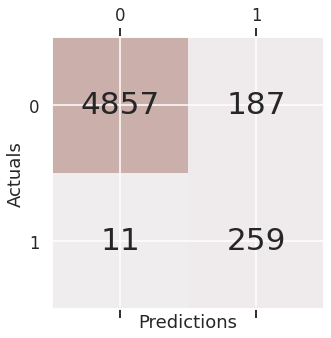

In [46]:
# Print the confusion matrix using Matplotlib

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [47]:
test_flower.to_csv("/content/test.csv", index = False)